## 1. Download data

In [2]:
import roboflow

roboflow.login()

roboflow.download_dataset(dataset_url="https://universe.roboflow.com/team-roboflow/coco-128/dataset/2", model_format="coco", location="data/coco-128")

You are already logged into Roboflow. To make a different login,run roboflow.login(force=True).
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to data/coco-128 in coco:: 100%|██████████| 386/386 [00:04<00:00, 84.22it/s] 


## 2. Create database

In [45]:
import glob
import json
from PIL import Image
from pathlib import Path

import clip
import faiss
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset


class ImageDataset(Dataset):
    def __init__(self, image_paths, preprocess):
        self.image_paths = image_paths
        self.preprocess = preprocess

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        image = self.preprocess(image)
        return image


def get_data_paths(dir: str | list[str], data_formats: list, prefix: str = '') -> list[str]:
    """
    Get list of files in a folder that have a file extension in the data_formats.

    Args:
      dir (str | list[str]): Dir or list of dirs containing data.
      data_formats (list): List of file extensions. Ex: ['jpg', 'png']
      prefix (str): Prefix for logging messages.

    Returns:
      A list of strings.
    """
    try:
        f = []  # data files
        for d in dir if isinstance(dir, list) else [dir]:
            p = Path(d)
            if p.is_dir():
                f += glob.glob(str(p / '**' / '*.*'), recursive=True)
            else:
                raise FileNotFoundError(f'{prefix}{p} does not exist')
        data_files = sorted(x for x in f if x.split('.')[-1].lower() in data_formats)
        return data_files
    except Exception as e:
        raise Exception(f'{prefix}Error loading data from {dir}: {e}') from e


def get_image_embeddings(data_dir, model_name="ViT-B/32", batch_size=32, device="cpu"):
    # Load the CLIP model
    model, preprocess = clip.load(model_name, device=device)
    
    # Create a dataset and dataloader
    image_paths = get_data_paths(data_dir, data_formats=["jpg", "jpeg", "png"])
    print(len(image_paths))
    dataset = ImageDataset(image_paths, preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=4)
    
    # List to store image embeddings
    image_embeddings = []

    # Process images in batches
    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            embeddings = model.encode_image(images)
            embeddings /= embeddings.norm(dim=-1, keepdim=True)
            image_embeddings.append(embeddings.cpu().numpy())

    # Convert list to numpy array
    image_embeddings = np.vstack(image_embeddings)
    
    return image_embeddings, image_paths


def create_faiss_index(embeddings):
    # Determine the dimensionality of the embeddings
    d = embeddings.shape[1]
    
    # Initialize a FAISS index
    index = faiss.IndexFlatL2(d)
    
    # Add embeddings to the index
    index.add(embeddings)
    
    return index


embeddings, image_paths = get_image_embeddings("data/coco-128/train", device="cuda")
index = create_faiss_index(embeddings)
faiss.write_index(index, "data/index.faiss")
with open("data/image_paths.json", "w") as f:
    json.dump(image_paths, f, indent=4)

128


## 3. Image-to-Image Search

In [ ]:
import json
from PIL import Image

import clip
import faiss
import torch


def load_faiss_index(index_path, image_paths_path):
    # Load FAISS index
    index = faiss.read_index(index_path)
    
    # Load image paths
    with open(image_paths_path, "r") as f:
        image_paths = json.load(f)
    
    return index, image_paths


def get_similar_images(images, index, image_paths, top_k=5, model_name="ViT-B/32", device="cpu"):
    # Load the CLIP model
    clip_model, clip_preprocess = clip.load(model_name, device=device)
    
    # Preprocess and get embeddings for input images
    processed_images = torch.stack([clip_preprocess(img) for img in images]).to(device)
    
    with torch.no_grad():
        embeddings = clip_model.encode_image(processed_images)
        embeddings /= embeddings.norm(dim=-1, keepdim=True)
        embeddings = embeddings.cpu().numpy()
    
    # Search for similar images
    D, I = index.search(embeddings, top_k)
    
    # Get the paths of the similar images
    similar_images = [[image_paths[i] for i in indices] for indices in I]
    print(similar_images)
    similar_images = [[Image.open(img_path) for img_path in paths] for paths in similar_images]
    
    return similar_images

In [41]:
# Example usage
device = "cuda" if torch.cuda.is_available() else "cpu"
index, image_paths = load_faiss_index("data/index.faiss", "data/image_paths.json")


query_images = ["data/coco-128/test/000000000034_jpg.rf.b518abdaed199dcb88854cf20fce8078.jpg", "data/coco-128/test/000000000283_jpg.rf.27927692baf616a7456bb3e24c21bfd7.jpg"]  # replace with your image paths
query_images = [Image.open(img_path) for img_path in query_images]
similar_images = get_similar_images(query_images , index, image_paths)

[['data/coco-128/train/000000000034_jpg.rf.a33e87d94b16c1112e8d9946fee784b9.jpg', 'data/coco-128/train/000000000154_jpg.rf.300698916140dd41f6fda1c194d7b00d.jpg', 'data/coco-128/train/000000000072_jpg.rf.244aee5e871d00c83983a224a5eb8ed5.jpg', 'data/coco-128/train/000000000025_jpg.rf.782fe78a513b7eeded6172306f4f502c.jpg', 'data/coco-128/train/000000000144_jpg.rf.09821163c359a738ad86e72865a310dc.jpg'], ['data/coco-128/train/000000000283_jpg.rf.5b072b49882659b6ec9c9454d9623390.jpg', 'data/coco-128/train/000000000092_jpg.rf.69d6172284e6afd6017db6ea911213ca.jpg', 'data/coco-128/train/000000000030_jpg.rf.15401567b6ff1d3787995bde6eeee471.jpg', 'data/coco-128/train/000000000308_jpg.rf.220721ec7c9e25fe8596c5c64cc84a2c.jpg', 'data/coco-128/train/000000000196_jpg.rf.8e48b2a4a9bd63fcd02ad61708d18ef2.jpg']]


### Visualize

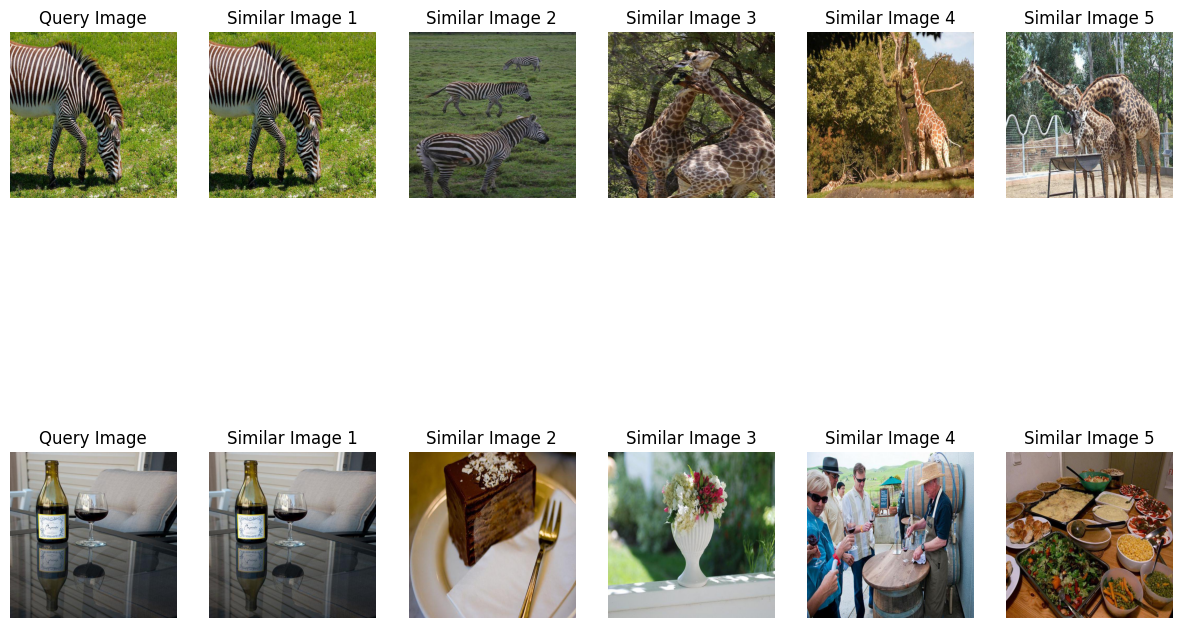

In [44]:
import matplotlib.pyplot as plt


def display_images(query_images, similar_images):
    num_queries = len(query_images)
    num_similar = len(similar_images[0])
    
    # Adjust subplots based on the number of queries
    if num_queries == 1:
        fig, axs = plt.subplots(1, num_similar + 1, figsize=(10, 5))
        axs = [axs]  # Make it iterable
    else:
        fig, axs = plt.subplots(num_queries, num_similar + 1, figsize=(15, 5 * num_queries))
    
    for i, query_image in enumerate(query_images):
        # Display query image
        axs[i][0].imshow(query_image)
        axs[i][0].set_title("Query Image")
        axs[i][0].axis("off")
        
        # Display similar images
        for j, sim_image in enumerate(similar_images[i]):
            axs[i][j + 1].imshow(sim_image)
            axs[i][j + 1].set_title(f"Similar Image {j + 1}")
            axs[i][j + 1].axis("off")
    
    plt.show()


display_images(query_images, similar_images)